In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from dateutil.relativedelta import relativedelta
from datetime import datetime
import ast

In [ ]:

# Download NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Enhanced text preprocessing function
def enhanced_preprocess(text):
    if pd.isnull(text) or text == '':
        return ''

    # Text cleaning
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Remove URLs
    text = re.sub(r'\@\w+|\#\w+', '', text) # Remove mentions/hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Keep only letters
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenization and lemmatization
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    # Remove short words and stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens
              if word not in stop_words and len(word) > 2]

    return ' '.join(tokens)

In [ ]:
# Function to safely convert string representation of lists to actual lists
def safe_convert_to_list(x):
    if isinstance(x, str) and x.startswith('[') and x.endswith(']'):
        try:
            return ast.literal_eval(x)
        except:
            return [x]
    elif isinstance(x, list):
        return x
    else:
        return [x]


In [ ]:
# Function to parse date string
def parse_date(date_str):
    try:
        if pd.isna(date_str) or date_str in ['', 'N/A']:
            return None
        if isinstance(date_str, str) and date_str.lower() in ['current', 'till date', 'present']:
            return datetime.now()
        return datetime.strptime(str(date_str), '%b %Y')
    except ValueError:
        try:
            return datetime.strptime(str(date_str), '%Y-%m-%d')
        except:
            return None


In [ ]:
# Function to calculate experience in years
def calculate_experience(start_dates, end_dates):
    total_experience = 0

    # Convert inputs to lists if they aren't already
    start_dates = safe_convert_to_list(start_dates)
    end_dates = safe_convert_to_list(end_dates)

    # Ensure we have matching number of start and end dates
    num_periods = min(len(start_dates), len(end_dates))

    for i in range(num_periods):
        start_date = parse_date(start_dates[i])
        end_date = parse_date(end_dates[i])

        if start_date and end_date:
            # Ensure end date is after start date
            if end_date < start_date:
                continue

            delta = relativedelta(end_date, start_date)
            total_experience += delta.years + delta.months/12 + delta.days/365

    return round(total_experience, 2)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/')
!ls

'Accuracy: 0.72_Resume_Screening_KNN.ipynb'
'Another copy of Resume Screening with KNN ML '
 Candidate_Recommending_System.ipynb
'Copy of final model of resume Sceening'
'Copy of final model of resume Sceening (1)'
'Copy of jobRecommender.ipynb'
'Copy of notebook8d9d15b57c'
'Copy of notebook97af9e7900'
'Copy of notebook97af9e7900 (1)'
'Copy of Resume Screening with KNN ML '
'Copy of Resume Screening with KNN ML  (1)'
'Copy of Resume Screening with KNN ML  (2)'
'Copy of Resume_Screening_with_NLP_prototype.ipynb'
'Copy of Updated_Resume_Screening_KNN.ipynb'
 correlation_matrix.png
 enhanced_job_recommendations.csv
'final model of resume Sceening.ipynb'
 Final_Resume_Screening_KNN.ipynb
'Iqra Mahmood Resume-5.pdf'
 job_recommendation_kmeans.csv
 job_recommendations_optimized.csv
 jobRecommender.ipynb
 Job_Requirement_Analysis_K_Means_Text_Clustering.ipynb
 Modified.csv
'Muhammad Murtza.pdf'
 MuhammadUsman.pdf
 M.Usman.pdf
 pone.0255419.s001.xlsx
 prediction_plot.png
 regression_results.pn

In [ ]:
# Load Dataset
df = pd.read_csv('resume_data.csv', encoding='utf-8-sig')
df.fillna('', inplace=True)

In [ ]:
# Calculate experience for each candidate
print("Calculating work experience for each candidate...")
df['Experience_Years'] = df.apply(lambda x: calculate_experience(x['start_dates'], x['end_dates']), axis=1)

Calculating work experience for each candidate...


In [ ]:
# Display experience distribution
print("\nExperience Distribution:")
print(df['Experience_Years'].describe())


Experience Distribution:
count    9544.000000
mean        2.077578
std         5.626417
min         0.000000
25%         0.000000
50%         0.000000
75%         1.080000
max        51.680000
Name: Experience_Years, dtype: float64


In [ ]:
# Combine text features - convert all non-string fields to strings first
df['Resume_Text'] = (
    df['career_objective'].astype(str) + ' ' +
    df['skills'].astype(str) + ' ' +
    df['major_field_of_studies'].astype(str) + ' ' +
    df['professional_company_names'].astype(str) + ' ' +
    df['positions'].astype(str) + ' ' +
    df['responsibilities'].astype(str) + ' ' +
    df['Experience_Years'].astype(str)
)

df['Job_Description_Text'] = (
    df['job_position_name'].astype(str) + ' ' +
    df['skills_required'].astype(str) + ' ' +
    df['responsibilities.1'].astype(str) + ' ' +
    df['experiencere_requirement'].astype(str)
)

In [ ]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab') # Add this line

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Apply enhanced preprocessing
df['Cleaned_Resume'] = df['Resume_Text'].apply(enhanced_preprocess)
df['Cleaned_Job_Desc'] = df['Job_Description_Text'].apply(enhanced_preprocess)

In [ ]:
# TF-IDF Vectorization with n-grams
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
resume_tfidf = vectorizer.fit_transform(df['Cleaned_Resume'])
jobdesc_tfidf = vectorizer.transform(df['Cleaned_Job_Desc'])

In [ ]:
# Cosine similarity calculation
cosine_similarities = []
for i in range(len(df)):
    score = cosine_similarity(resume_tfidf[i], jobdesc_tfidf[i])[0][0]
    cosine_similarities.append(score)
df['Cosine_Similarity'] = cosine_similarities

In [ ]:
# Add additional features
df['Experience_Match'] = df.apply(lambda x: 1 if x['positions'] in x['job_position_name'] else 0, axis=1)
df['Education_Match'] = df.apply(lambda x: 1 if x['major_field_of_studies'] in x['educationaL_requirements'] else 0, axis=1)

In [ ]:
combined_features = np.hstack((
    resume_tfidf.toarray(),
    np.array(cosine_similarities).reshape(-1, 1),
    df[['Experience_Match', 'Education_Match']].values
))

In [ ]:
# Dimensionality reduction
svd = TruncatedSVD(n_components=100, random_state=42)
reduced_features = svd.fit_transform(combined_features)

In [ ]:
normalizer = Normalizer()
normalized_features = normalizer.fit_transform(reduced_features)

Determining optimal number of clusters...


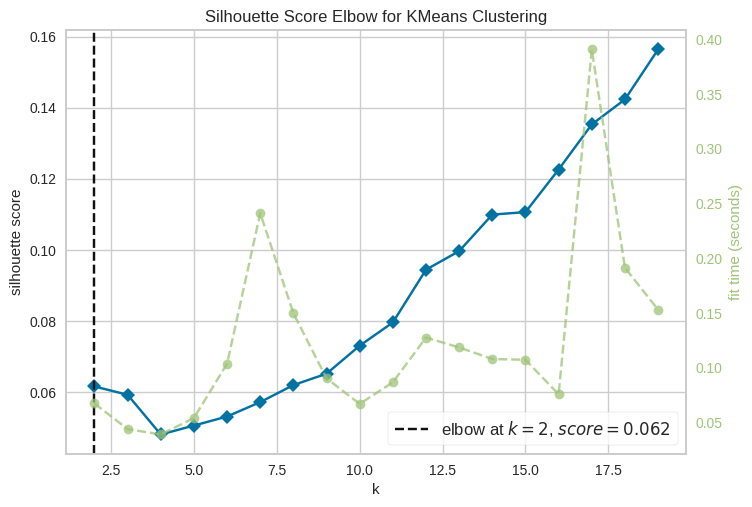

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [ ]:
# Determine optimal number of clusters
print("Determining optimal number of clusters...")
visualizer = KElbowVisualizer(KMeans(random_state=42), k=(2,20), metric='silhouette')
visualizer.fit(normalized_features)
visualizer.show()

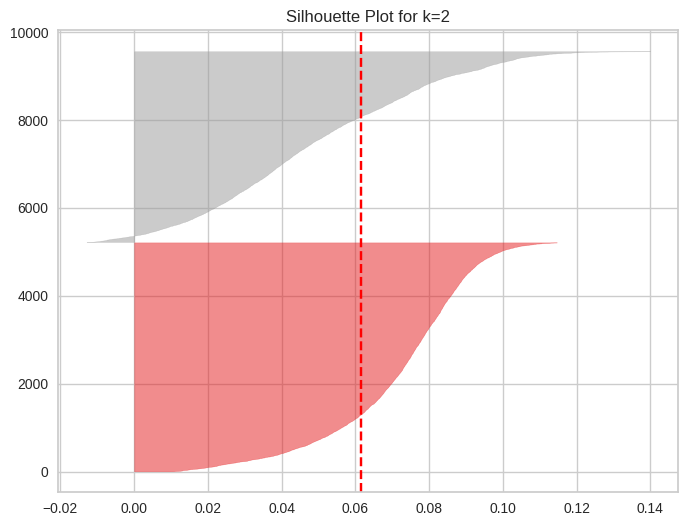

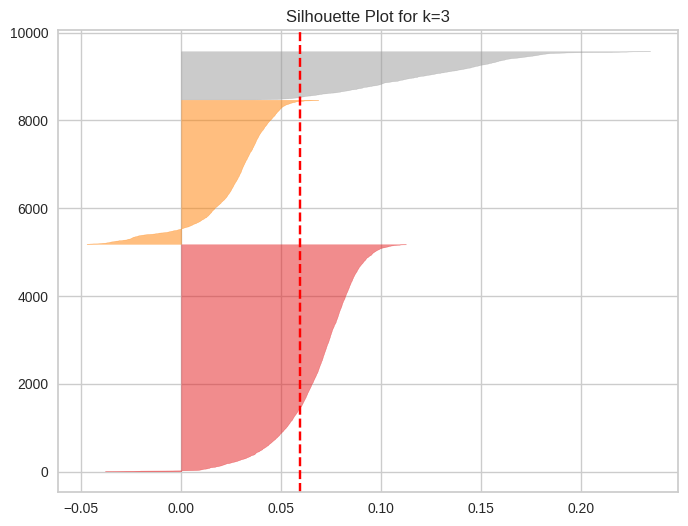

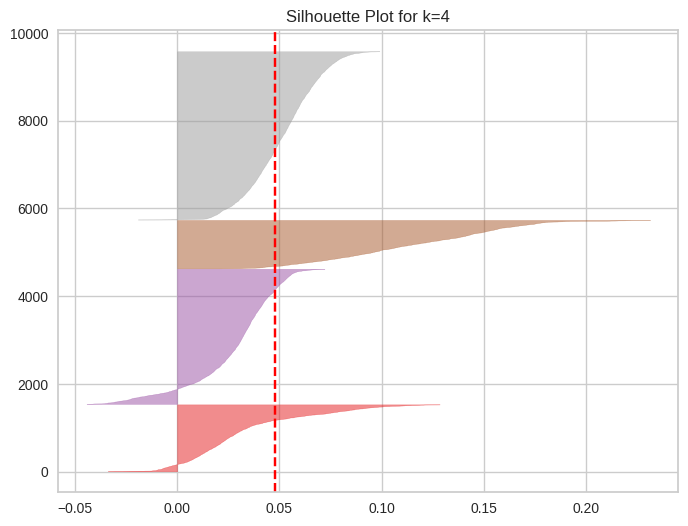

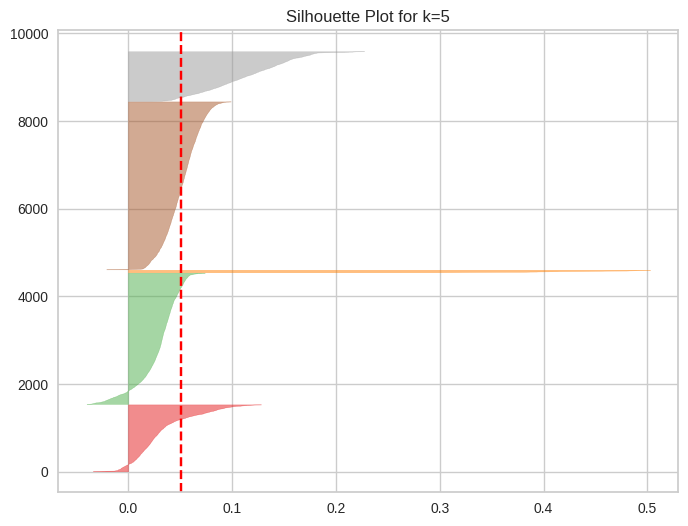

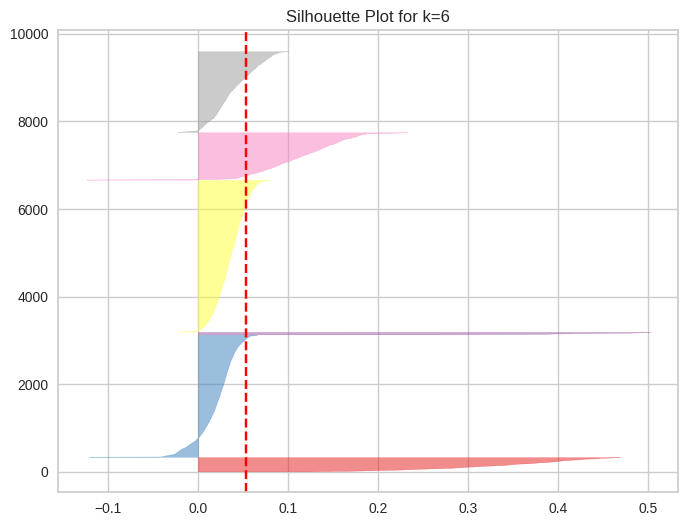

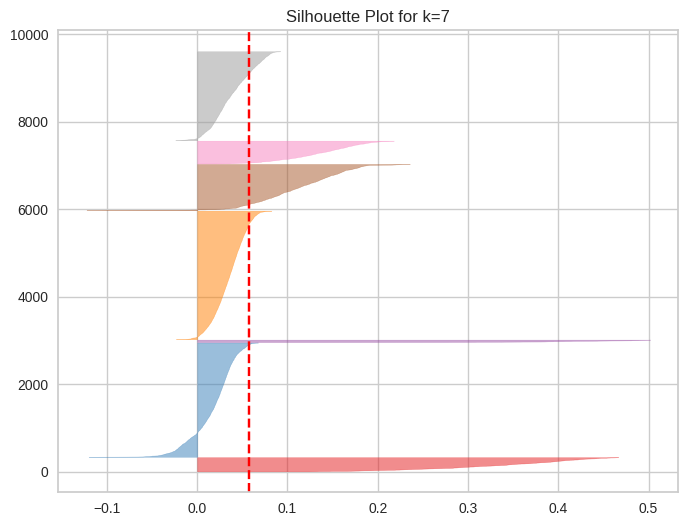

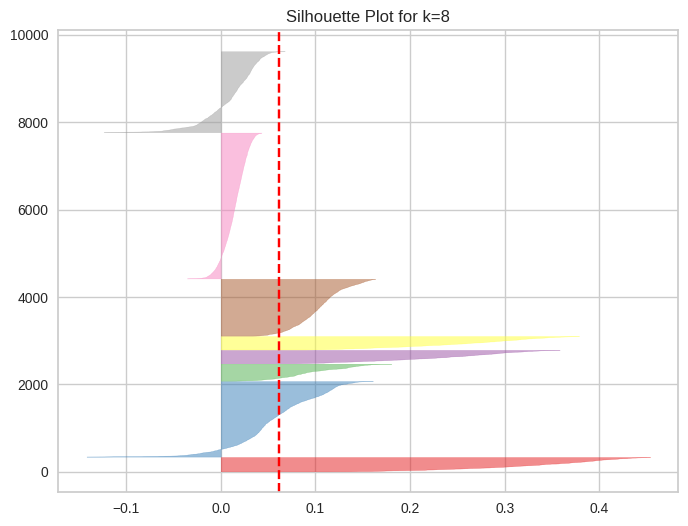

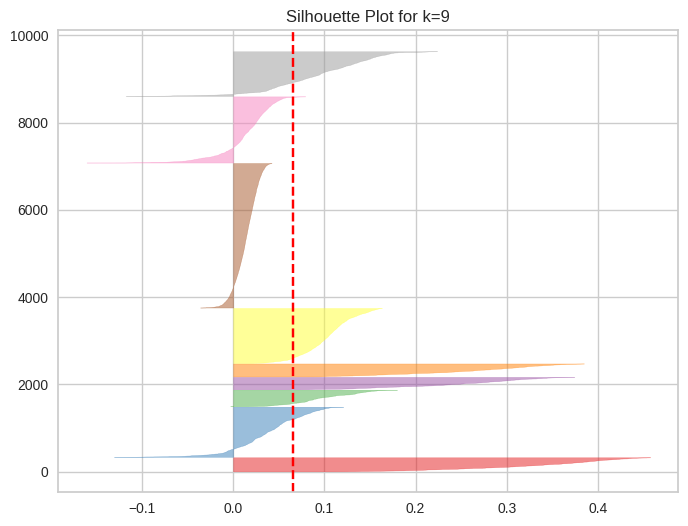

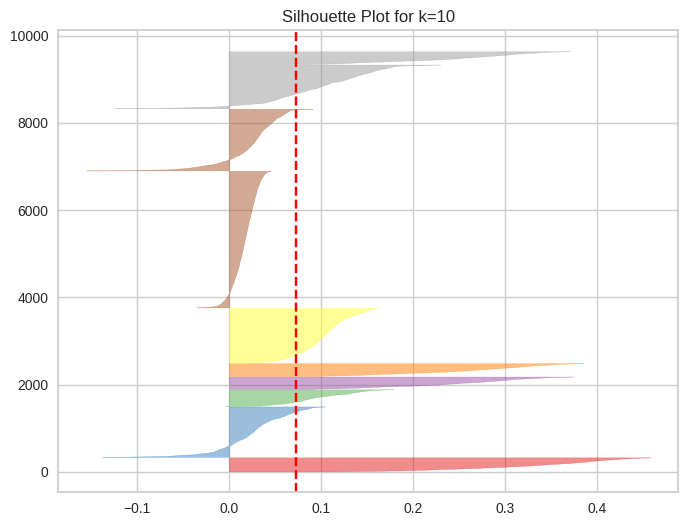

In [ ]:
for k in range(2, 11):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    visualizer = SilhouetteVisualizer(KMeans(n_clusters=k, random_state=42), ax=ax)
    visualizer.fit(normalized_features)
    plt.title(f'Silhouette Plot for k={k}')
    plt.show()

Determining optimal number of clusters...


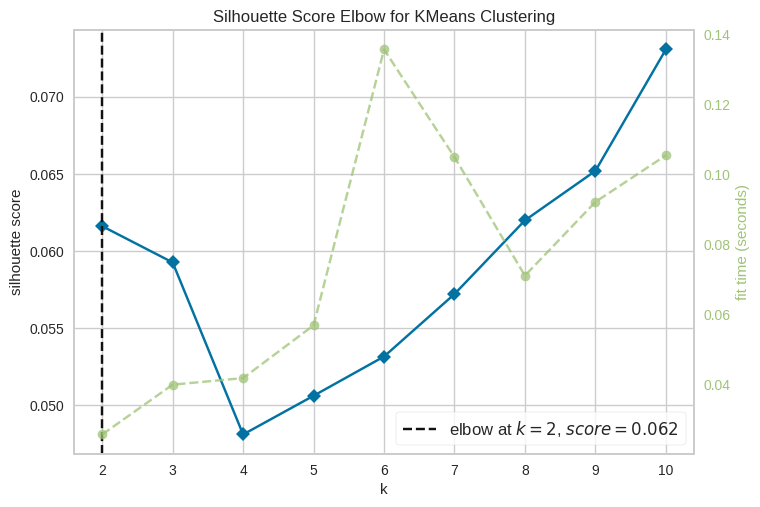


Optimal number of clusters: 2


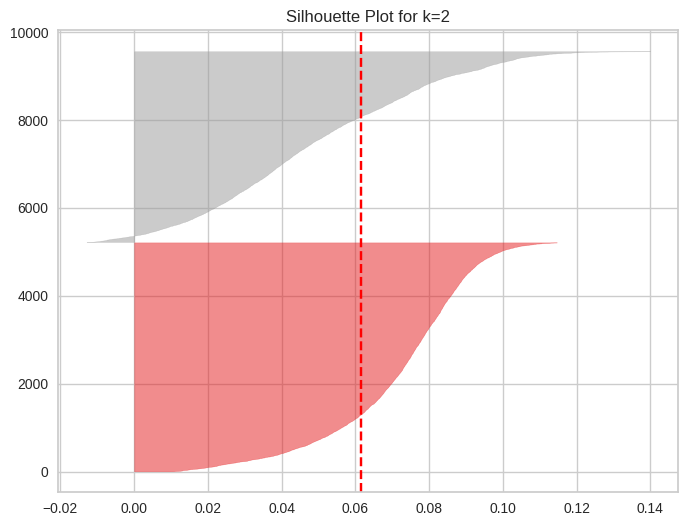

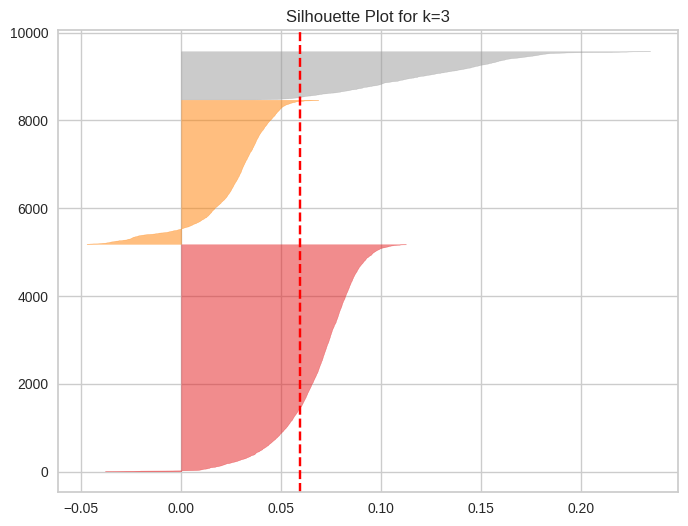

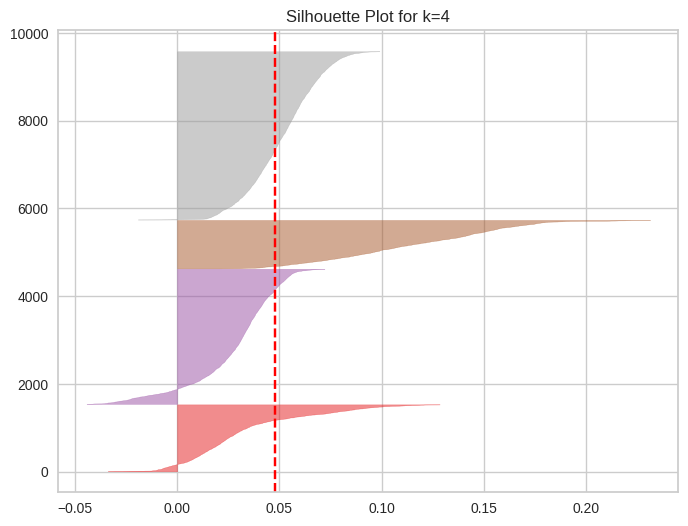

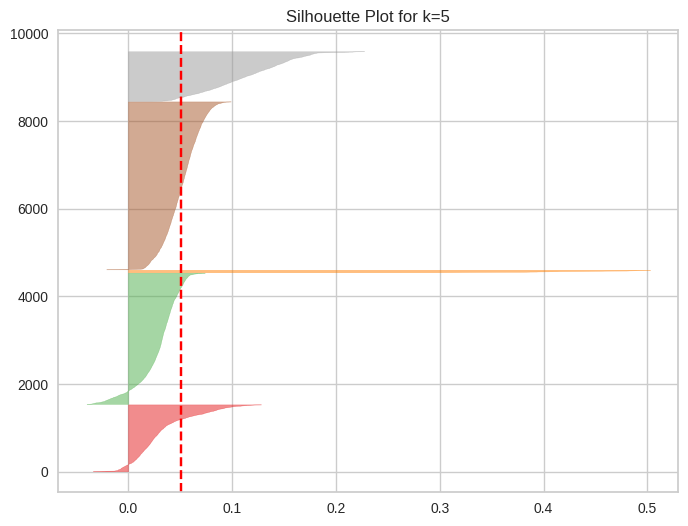

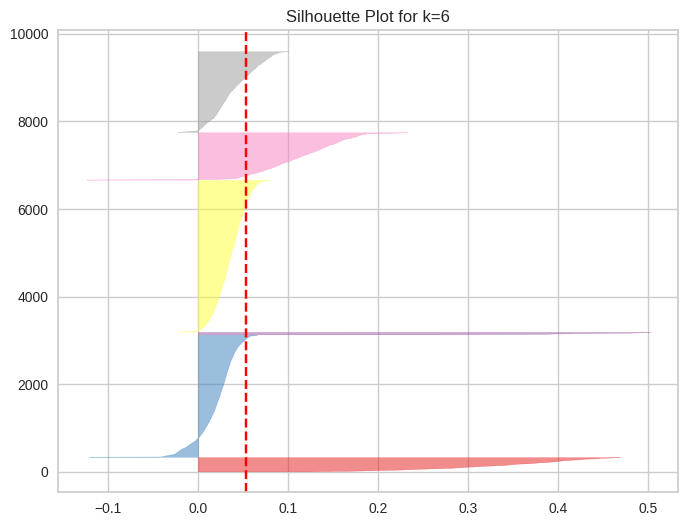

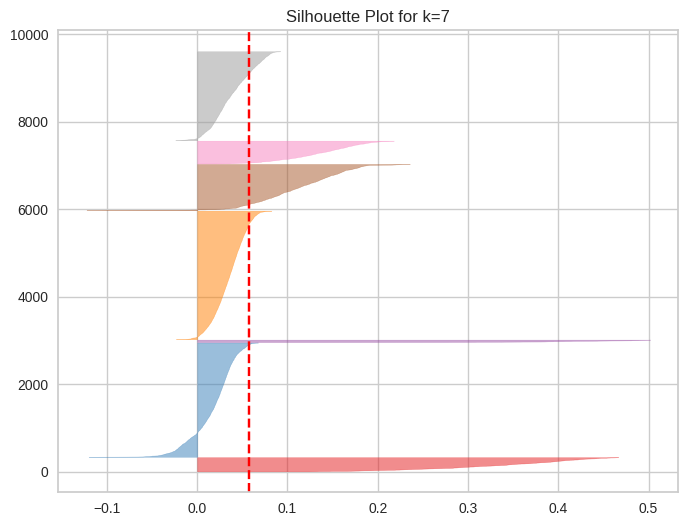

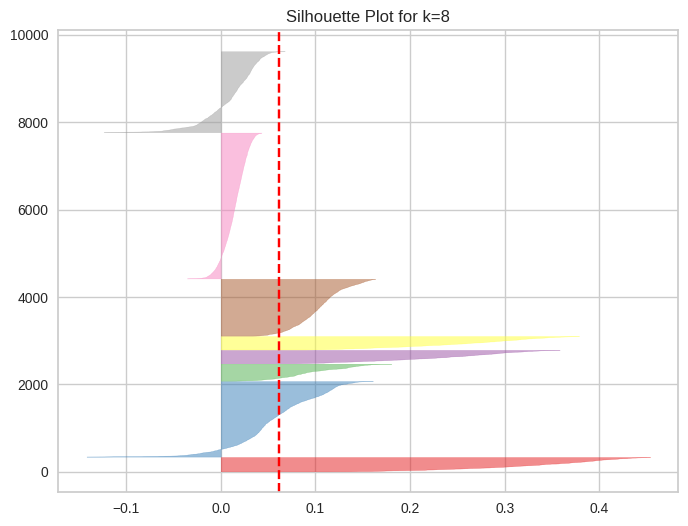

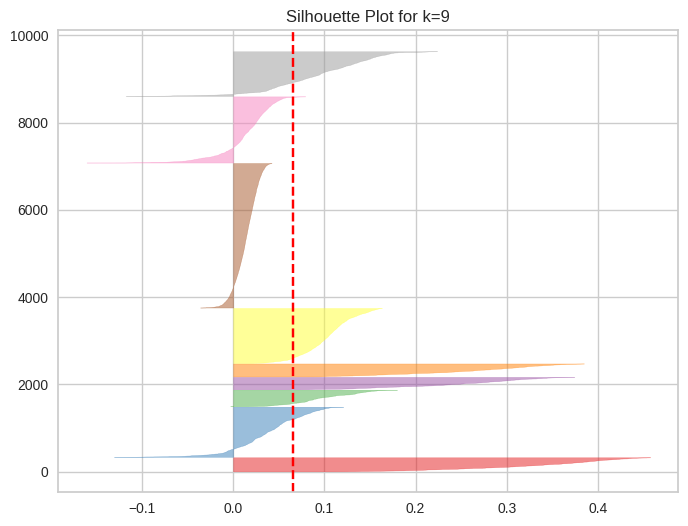

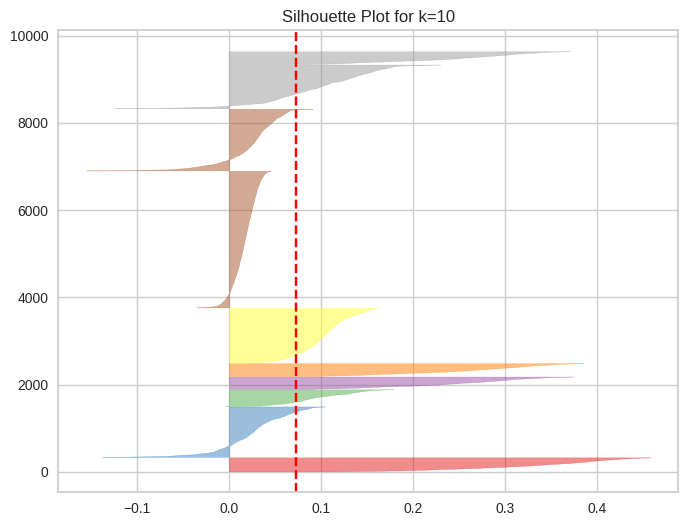

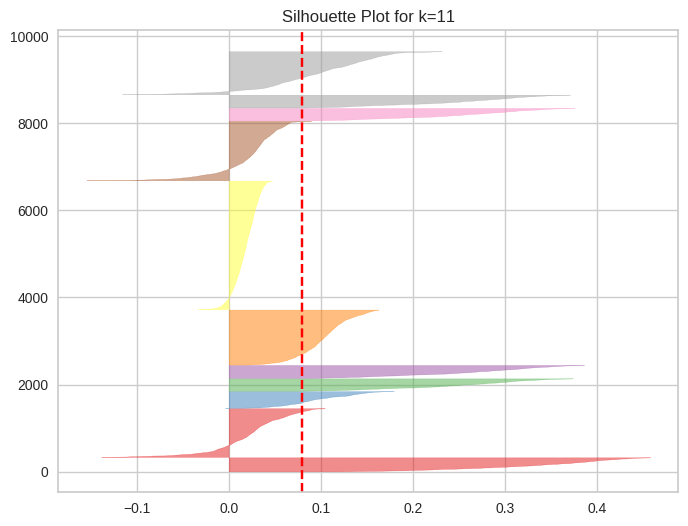

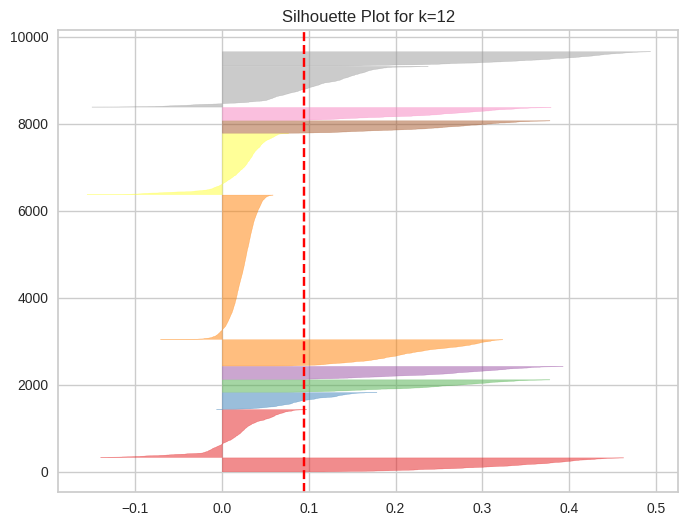

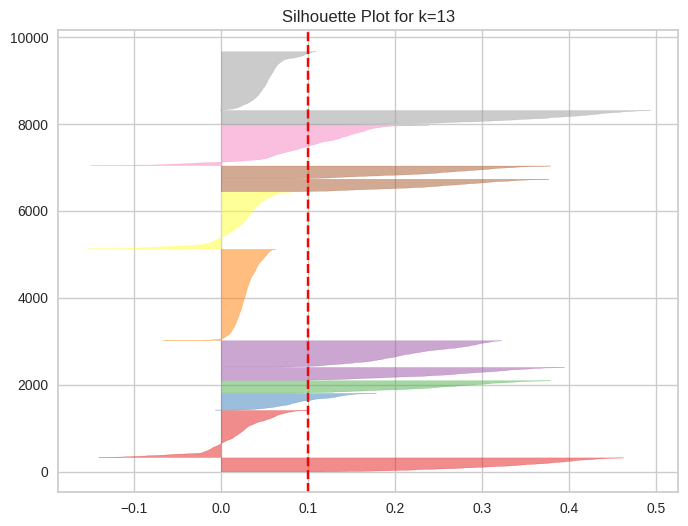

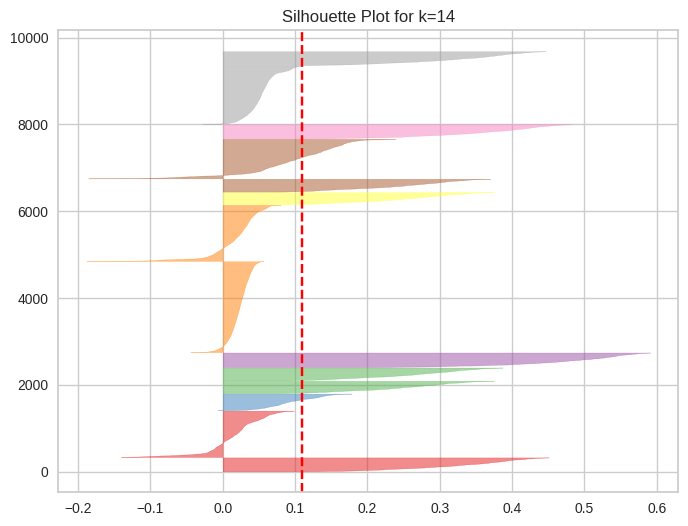

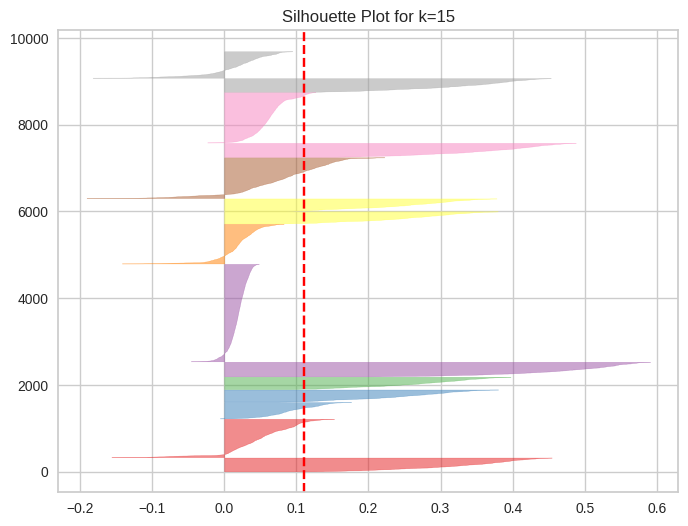

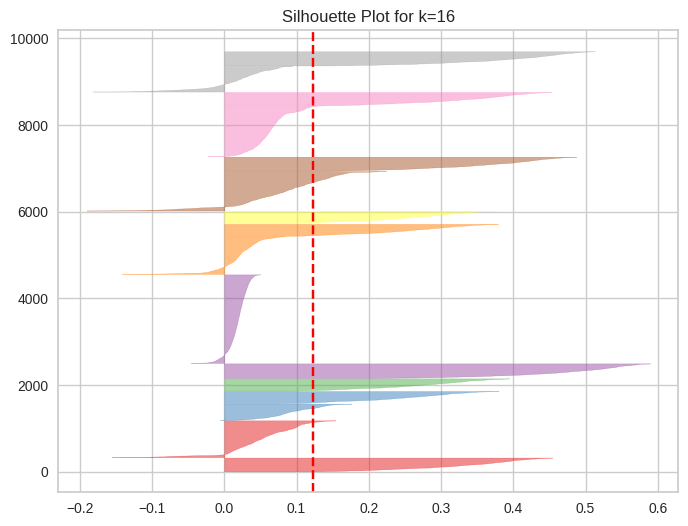

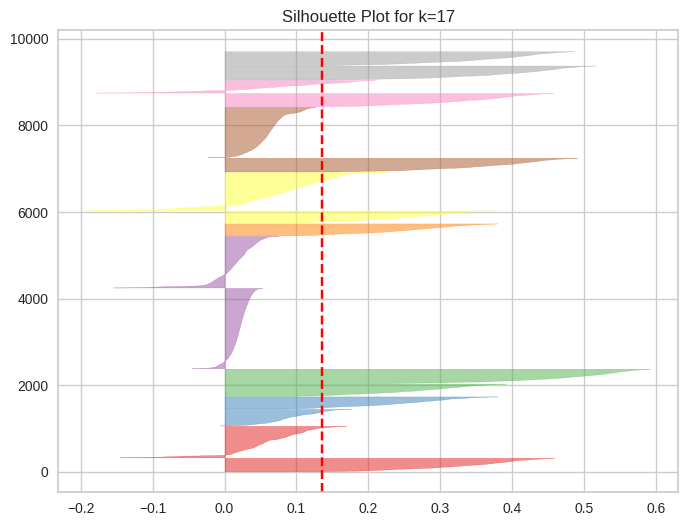

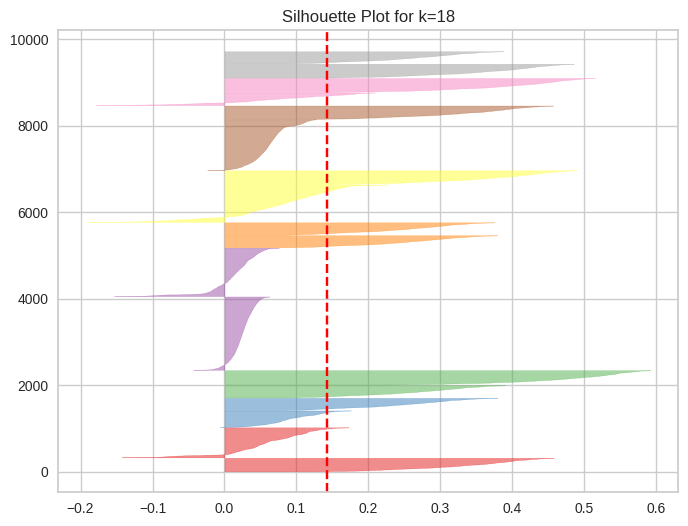

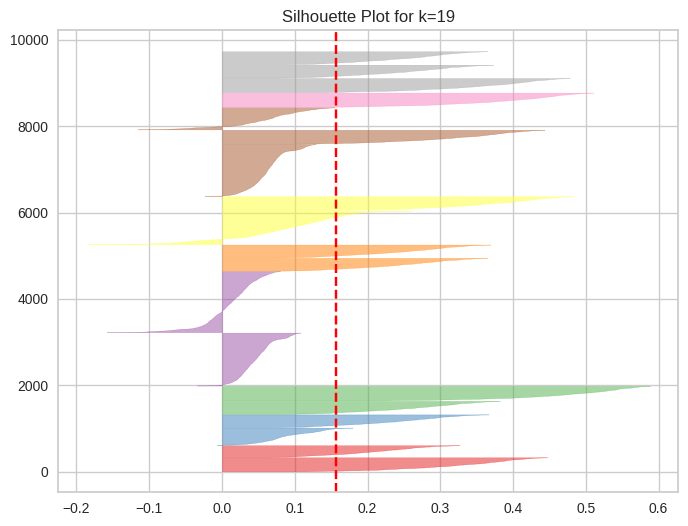

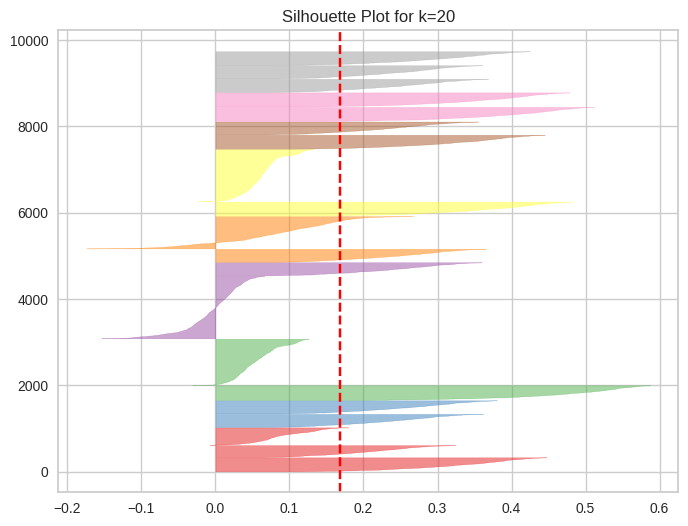

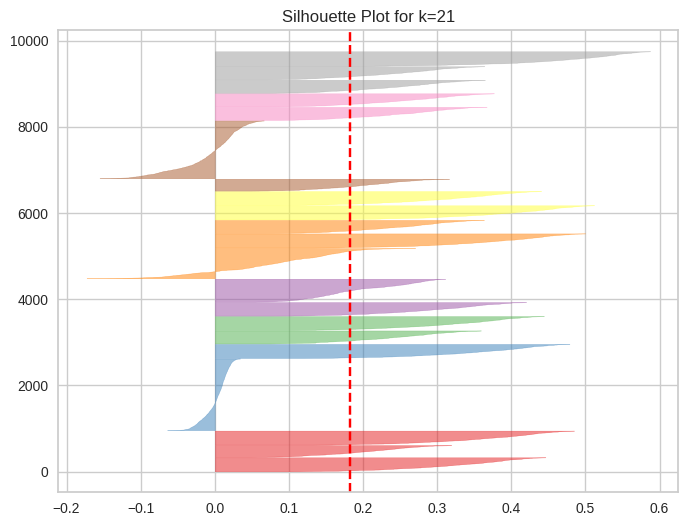

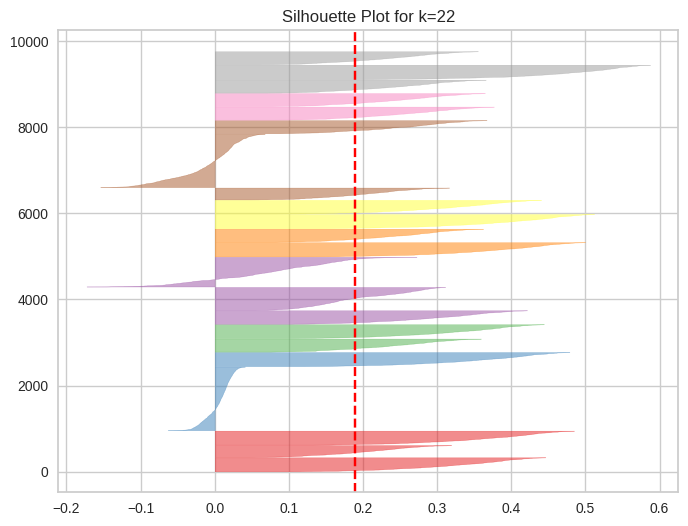

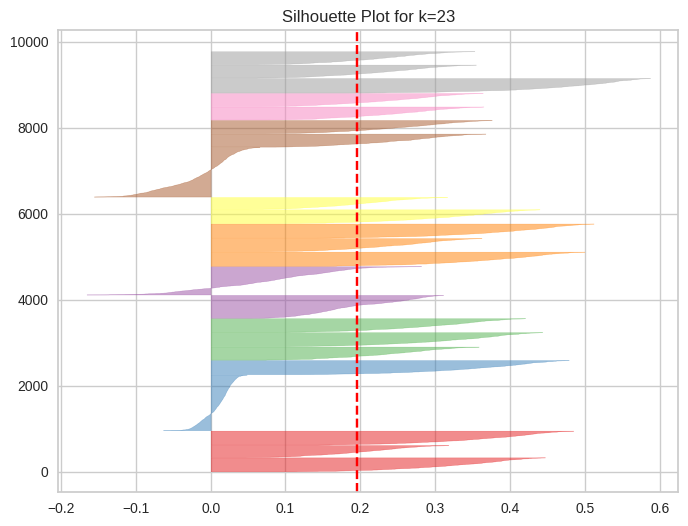

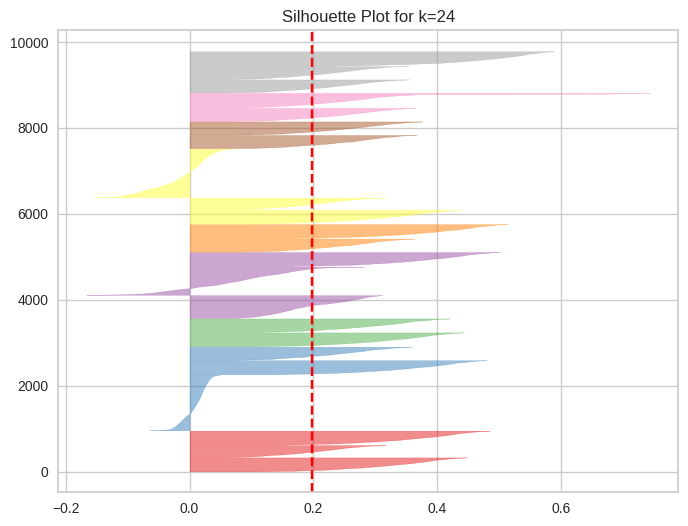

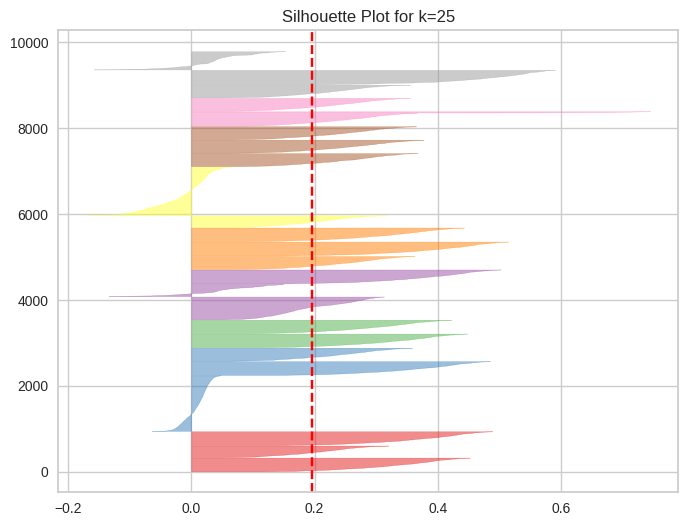

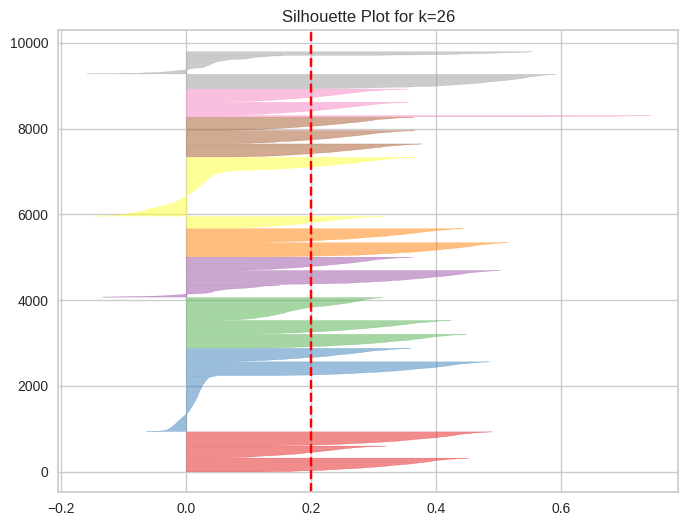

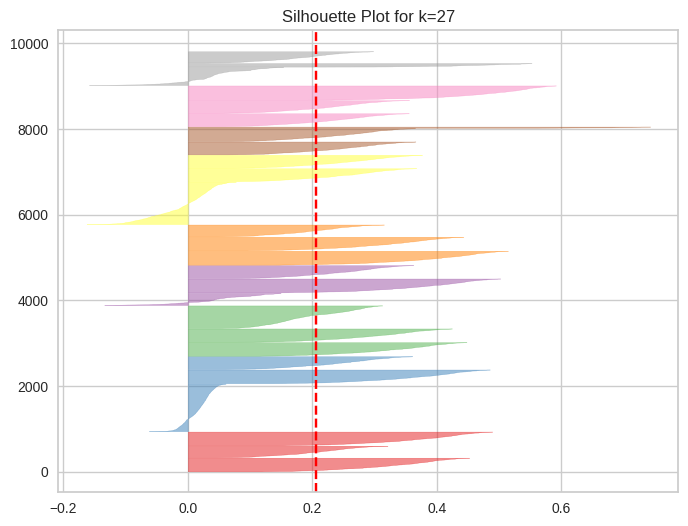

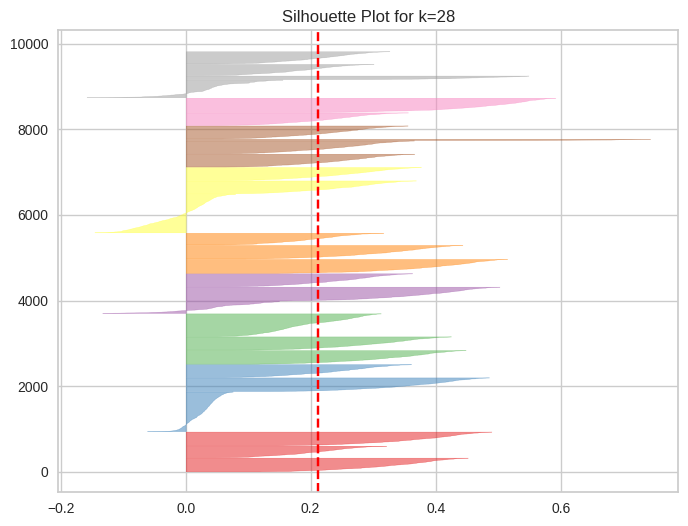

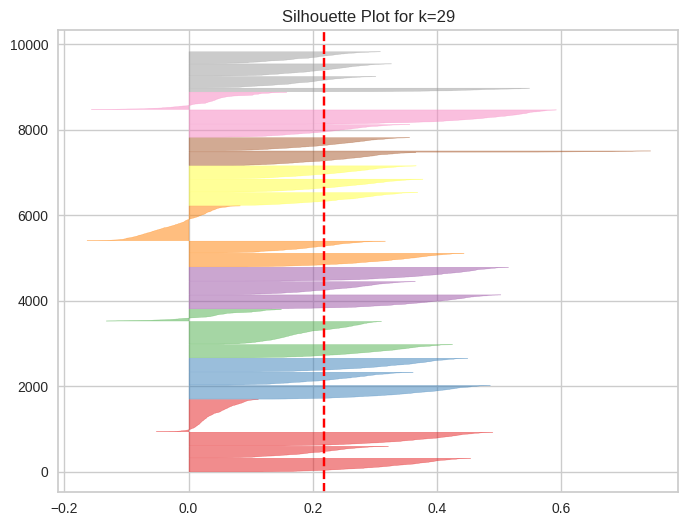

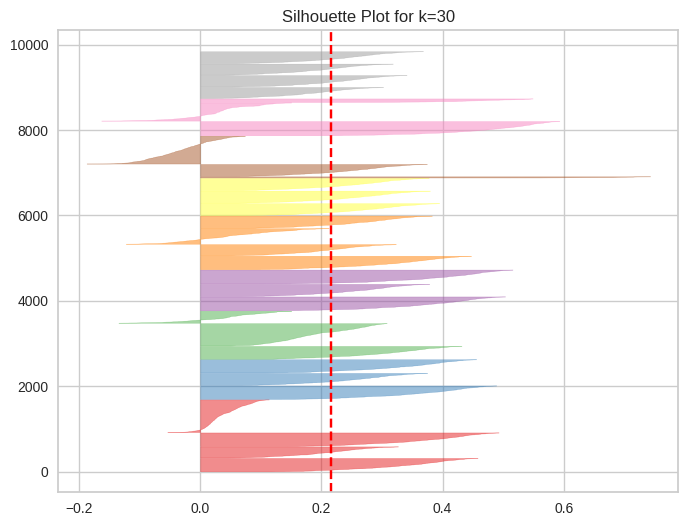

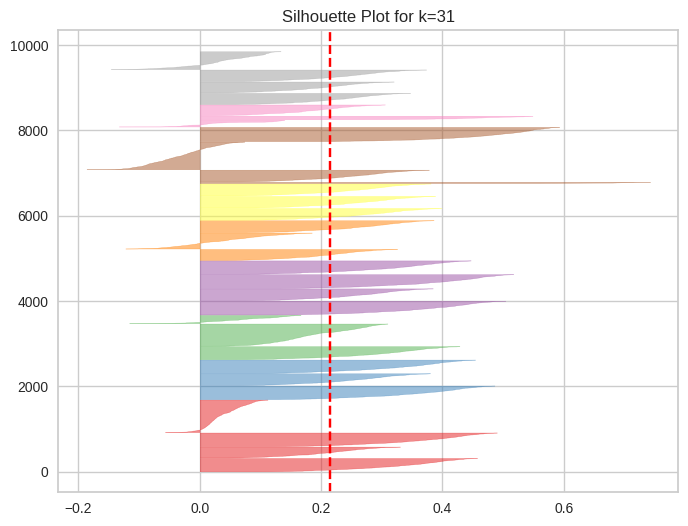

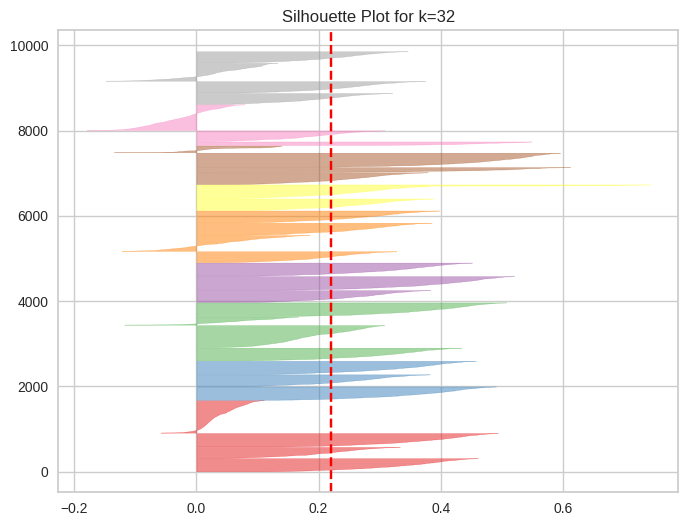

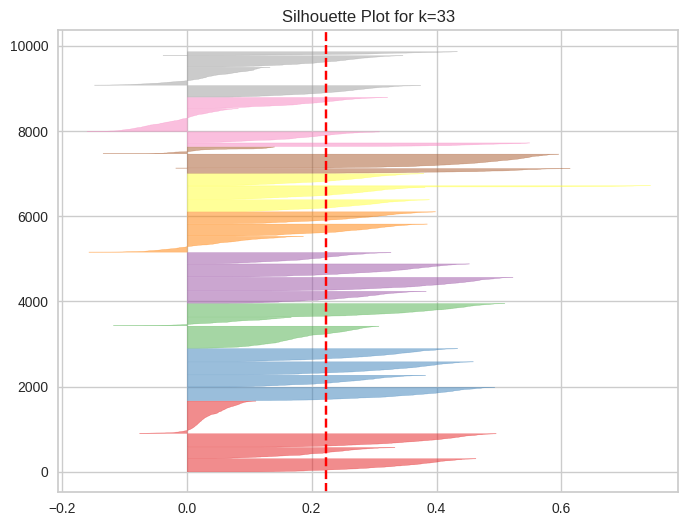

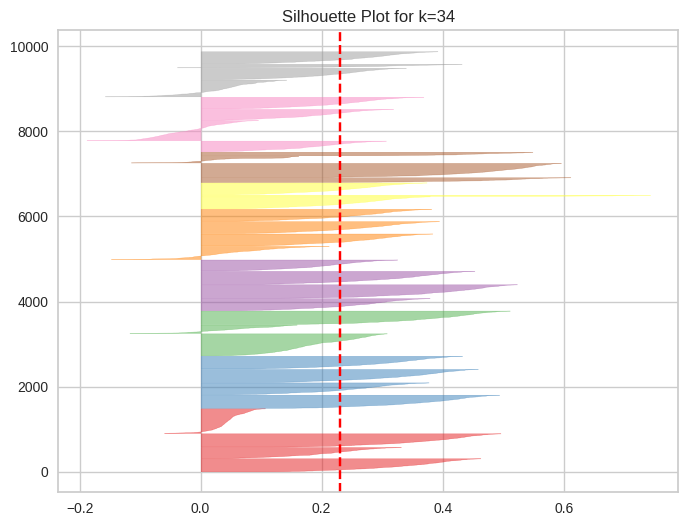

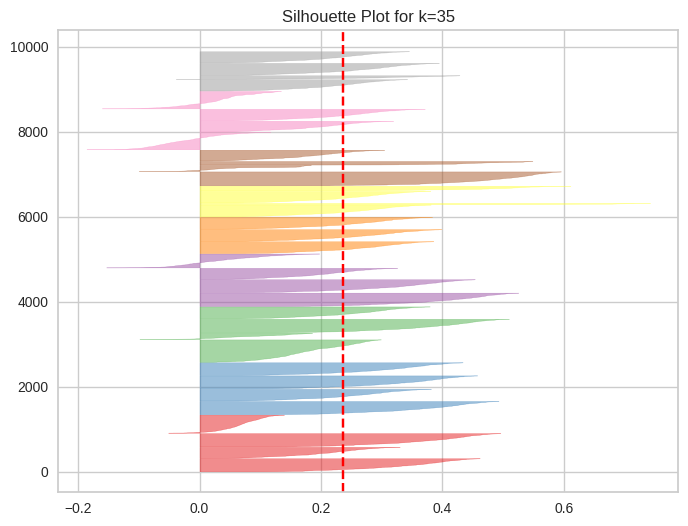

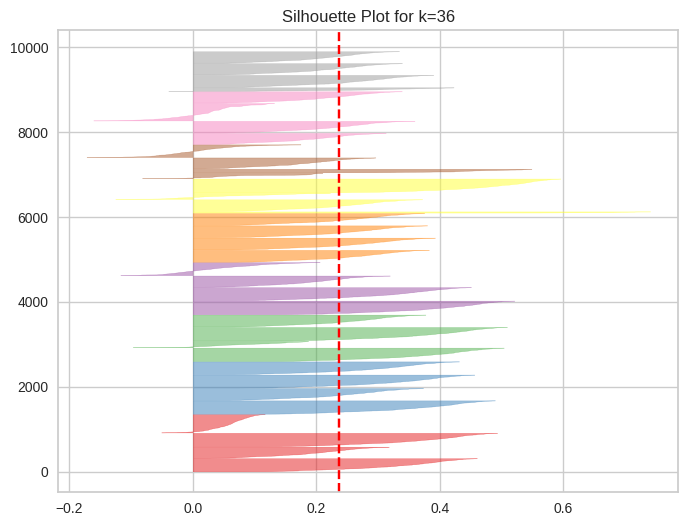

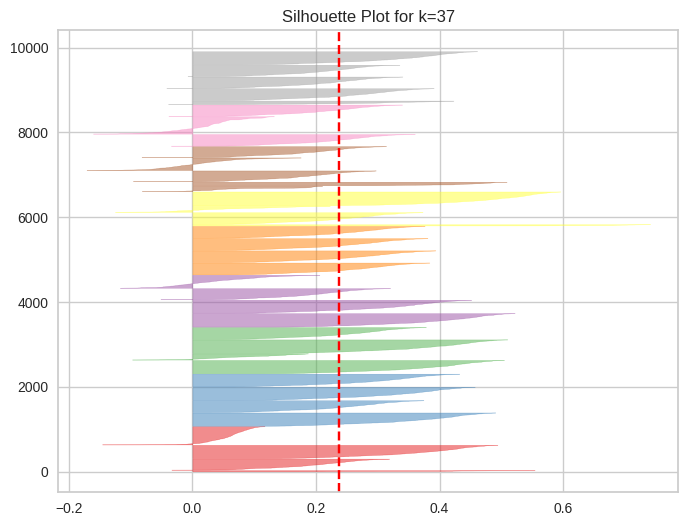

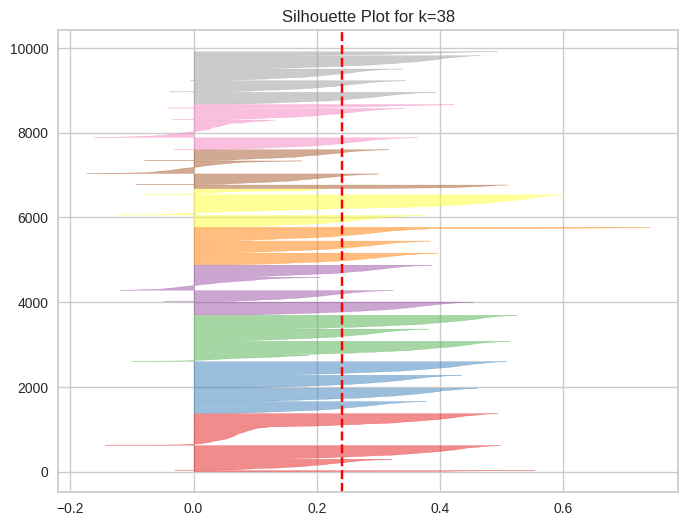

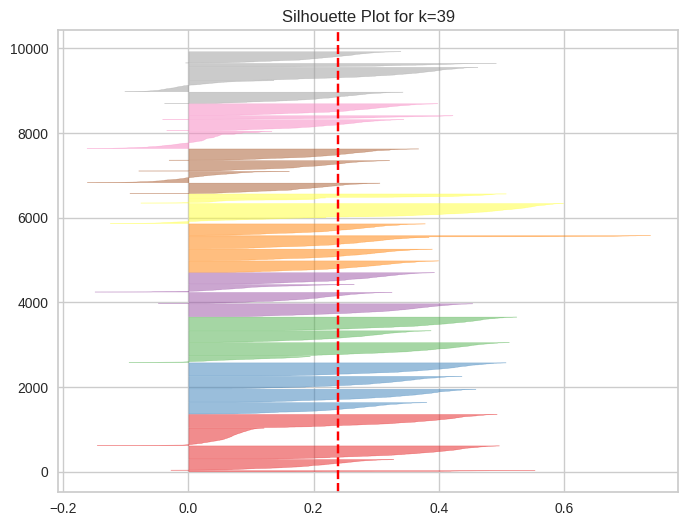

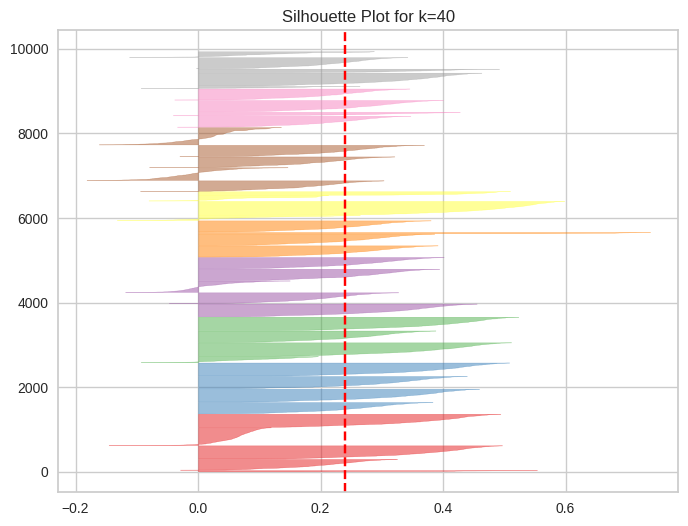

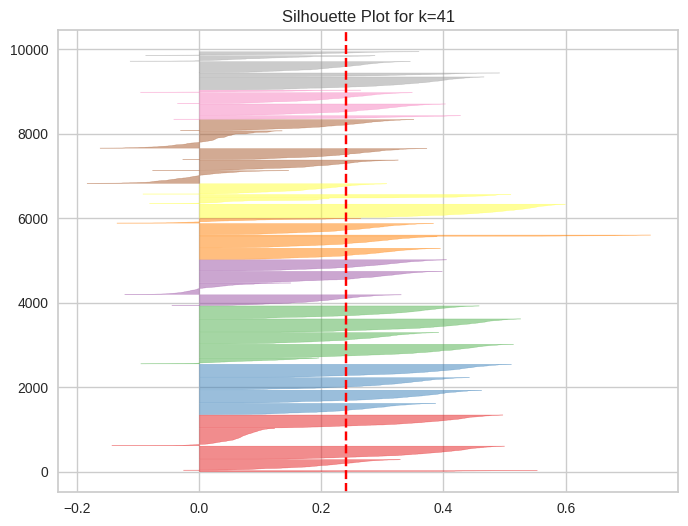

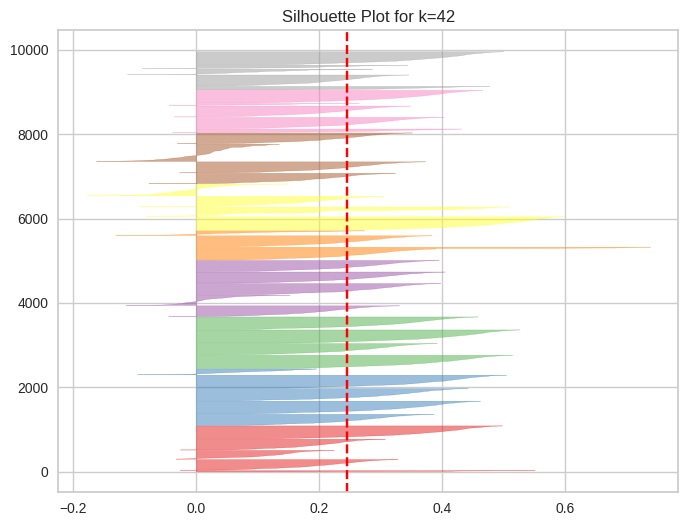

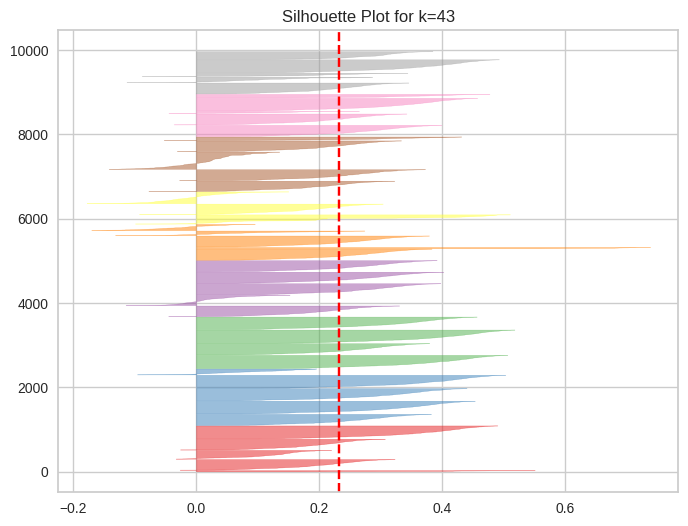

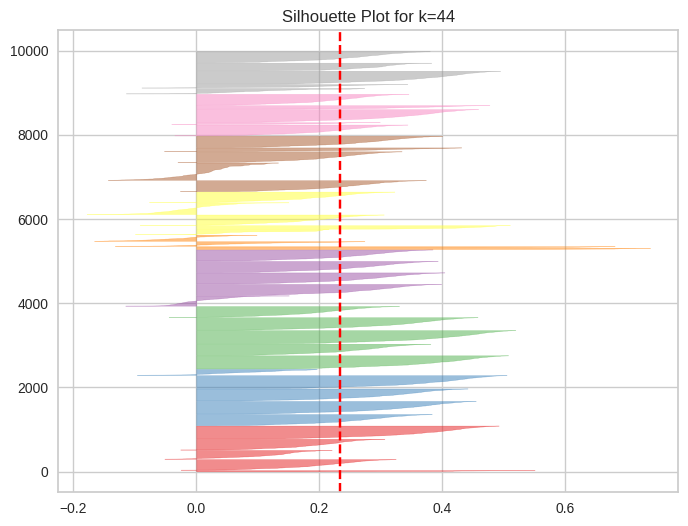

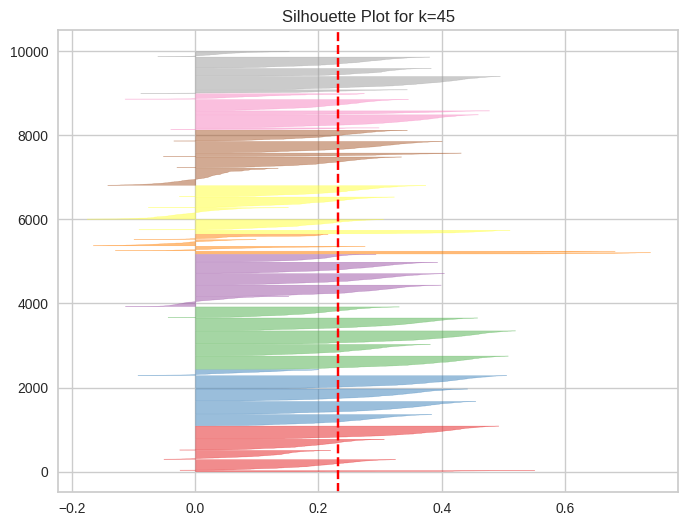

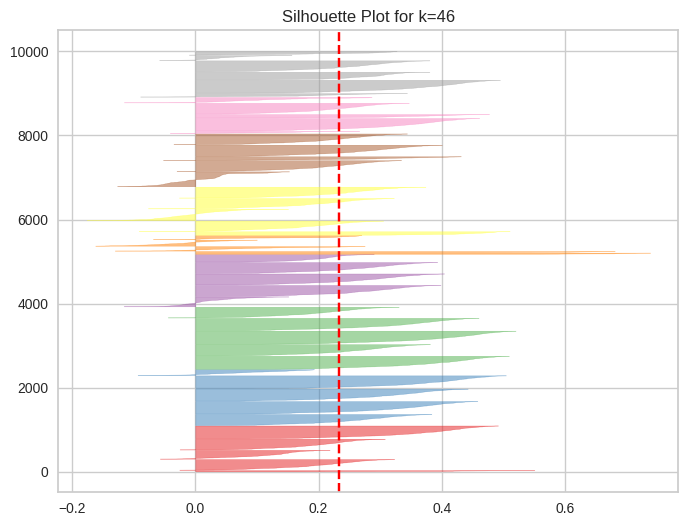

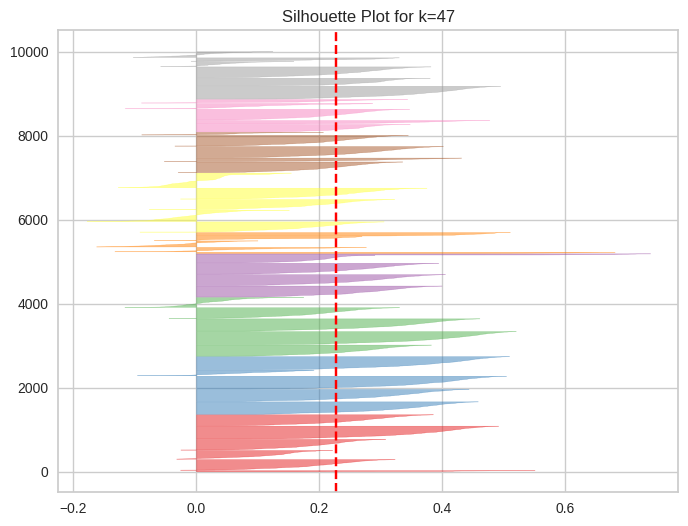

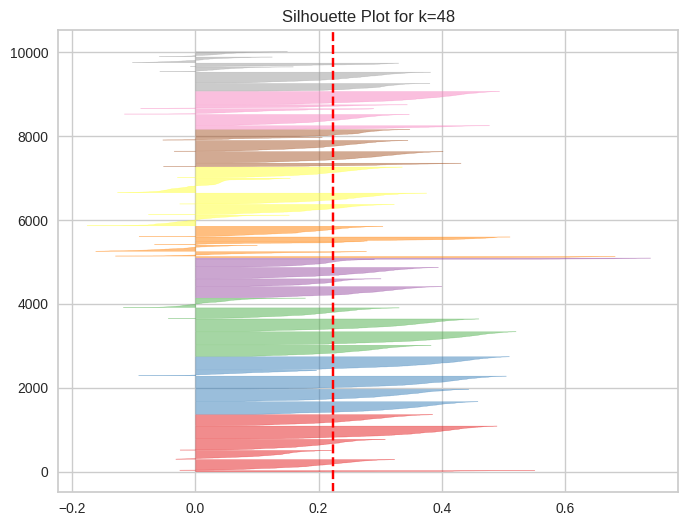

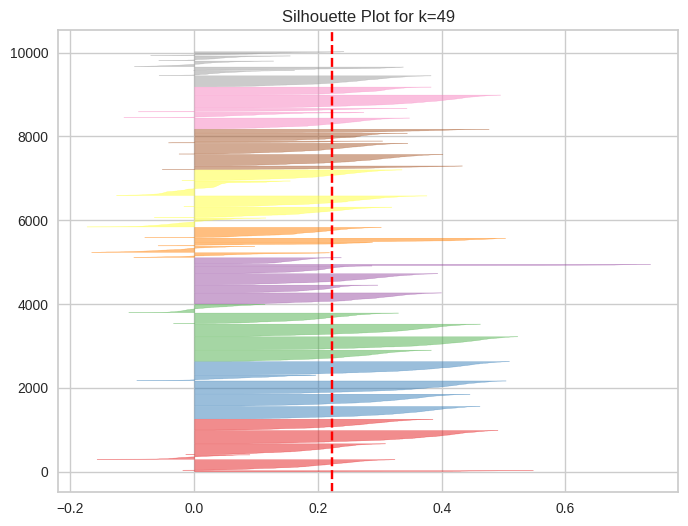

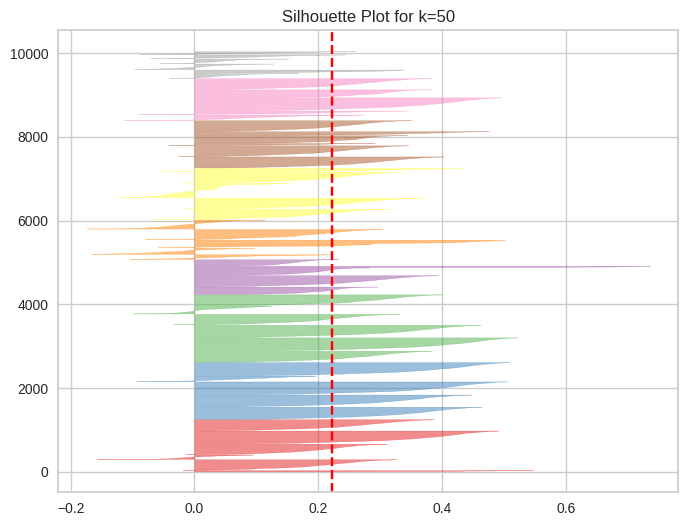

In [ ]:
# Determine optimal number of clusters
print("Determining optimal number of clusters...")
elbow_visualizer = KElbowVisualizer(KMeans(random_state=42), k=(2,11), metric='silhouette')
elbow_visualizer.fit(normalized_features)
elbow_visualizer.show()

# Use the elbow value from the KElbowVisualizer
best_k = elbow_visualizer.elbow_value_ if elbow_visualizer.elbow_value_ else 7  # Default to 7 if elbow not clear
print(f"\nOptimal number of clusters: {best_k}")

for k in range(2, 51):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    # You can still use SilhouetteVisualizer to visualize individual silhouette scores
    silhouette_visualizer = SilhouetteVisualizer(KMeans(n_clusters=k, random_state=42), ax=ax)
    silhouette_visualizer.fit(normalized_features)
    plt.title(f'Silhouette Plot for k={k}')
    plt.show()

# Final clustering with optimal K
kmeans = KMeans(n_clusters=best_k, random_state=42)
df['cluster_id'] = kmeans.fit_predict(normalized_features)

# from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score
# import matplotlib.pyplot as plt

# # Step 1: Determine optimal number of clusters using KElbowVisualizer
# print("🔍 Determining optimal number of clusters...")
# elbow_visualizer = KElbowVisualizer(KMeans(random_state=42), k=(2, 11), metric='silhouette')
# elbow_visualizer.fit(normalized_features)
# elbow_visualizer.show()

# # Step 2: Use elbow value from visualizer or default to 7
# best_k = elbow_visualizer.elbow_value_ if elbow_visualizer.elbow_value_ else 7
# print(f"\n✅ Initial optimal number of clusters from elbow visualizer: k = {best_k}")

# # Step 3: Evaluate silhouette score for each k and display visualization
# print("\n📊 Silhouette Scores for k = 2 to 50:\n")
# scores_dict = {}  # to store scores for summary

# for k in range(2, 51):
#     kmeans_model = KMeans(n_clusters=k, random_state=42)
#     labels = kmeans_model.fit_predict(normalized_features)
#     score = silhouette_score(normalized_features, labels)

#     # Print current k and score
#     print(f"  ➤ k = {k:2d}, Silhouette Score = {score:.4f}")
#     scores_dict[k] = score

#     # Plot silhouette visualization
#     fig, ax = plt.subplots(1, 1, figsize=(8, 6))
#     silhouette_visualizer = SilhouetteVisualizer(KMeans(n_clusters=k, random_state=42), ax=ax)
#     silhouette_visualizer.fit(normalized_features)
#     plt.title(f'Silhouette Plot for k={k}')
#     plt.show()

# # Step 4: Find the best k based on highest silhouette score
# true_best_k = max(scores_dict, key=scores_dict.get)
# true_best_score = scores_dict[true_best_k]

# print(f"\n🏁 Final Best k Based on Maximum Silhouette Score:")
# print(f"   ✅ Best k = {true_best_k}, Silhouette Score = {true_best_score:.4f}")

# # Step 5: Final clustering using best k
# kmeans = KMeans(n_clusters=true_best_k, random_state=42)
# df['cluster_id'] = kmeans.fit_predict(normalized_features)


In [ ]:
# Calculate final silhouette score
final_score = silhouette_score(normalized_features, df['cluster_id'])
print(f"\nFinal Silhouette Score: {final_score:.3f}")



Final Silhouette Score: 0.062


In [ ]:
# import matplotlib.pyplot as plt
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score
# from yellowbrick.cluster import SilhouetteVisualizer

# # 1. Determine best_k manually by computing silhouette scores
# print("Searching for optimal k using silhouette score...")
# silhouette_scores = []
# k_range = range(2, 11)

# for k in k_range:
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     labels = kmeans.fit_predict(normalized_features)
#     score = silhouette_score(normalized_features, labels)
#     silhouette_scores.append(score)

# # 2. Find k with the maximum silhouette score
# best_k = k_range[silhouette_scores.index(max(silhouette_scores))]
# print(f"\n✅ Optimal number of clusters based on silhouette score: k = {best_k} with score = {max(silhouette_scores):.3f}")

# # 3. Optional: Plot silhouette scores vs k
# plt.figure(figsize=(10, 6))
# plt.plot(k_range, silhouette_scores, marker='o', color='blue')
# plt.axvline(best_k, color='red', linestyle='--', label=f'Best k = {best_k}')
# plt.xlabel("Number of clusters (k)")
# plt.ylabel("Silhouette Score")
# plt.title("Silhouette Score vs Number of Clusters")
# plt.legend()
# plt.grid(True)
# plt.show()

# # 4. Optional: Show silhouette plots for all k (or selected k)
# # You can limit the range here if visualizing all takes too long
# for k in [best_k]:  # or use range(2, 11) to see multiple plots
#     fig, ax = plt.subplots(figsize=(8, 6))
#     silhouette_visualizer = SilhouetteVisualizer(KMeans(n_clusters=k, random_state=42), ax=ax)
#     silhouette_visualizer.fit(normalized_features)
#     plt.title(f'Silhouette Plot for k={k}')
#     plt.show()

# # 5. Final clustering with optimal K
# kmeans = KMeans(n_clusters=best_k, random_state=42)
# df['cluster_id'] = kmeans.fit_predict(normalized_features)


In [ ]:
# Map clusters to recommendations
def map_cluster_to_label(cluster):
    # Sort clusters by average cosine similarity to assign meaningful labels
    cluster_means = df.groupby('cluster_id')['Cosine_Similarity'].mean()
    sorted_clusters = cluster_means.sort_values(ascending=False).index

    if cluster == sorted_clusters[0]:
        return 'Highly Recommended'
    elif cluster == sorted_clusters[1]:
        return 'Moderately Recommended'
    elif cluster == sorted_clusters[2] if len(sorted_clusters) > 2 else -1:
        return 'Recommended'
    else:
        return 'Not Recommended'

df['Recommendation'] = df['cluster_id'].apply(map_cluster_to_label)


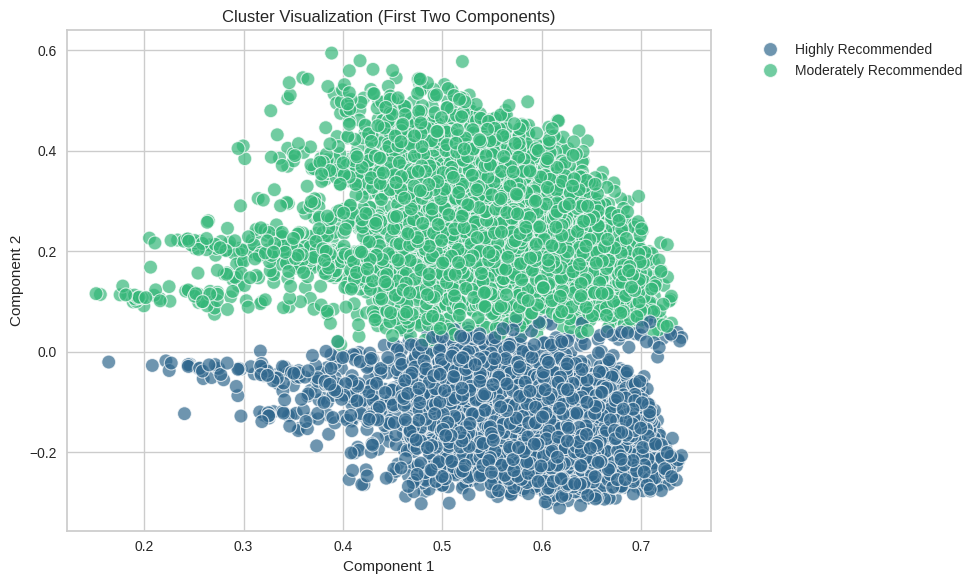

In [ ]:
# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=normalized_features[:, 0],
    y=normalized_features[:, 1],
    hue=df['Recommendation'],
    palette='viridis',
    s=100,
    alpha=0.7
)
plt.title('Cluster Visualization (First Two Components)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
output = df[['job_position_name', 'Recommendation', 'Cosine_Similarity',
             'Experience_Match', 'Education_Match', 'Experience_Years']]
print("\nSample recommendations with experience:")
print(output.head(10))



Sample recommendations with experience:
                                   job_position_name          Recommendation  \
0                           Senior Software Engineer      Highly Recommended   
1                     Machine Learning (ML) Engineer      Highly Recommended   
2  Executive/ Senior Executive- Trade Marketing, ...      Highly Recommended   
3                     Business Development Executive  Moderately Recommended   
4                                Senior iOS Engineer  Moderately Recommended   
5                                        AI Engineer  Moderately Recommended   
6                                Senior iOS Engineer      Highly Recommended   
7                                Senior iOS Engineer  Moderately Recommended   
8                                Mechanical Engineer      Highly Recommended   
9                     Business Development Executive      Highly Recommended   

   Cosine_Similarity  Experience_Match  Education_Match  Experience_Years  
0 

In [ ]:
# Save results
output.to_csv('enhanced_job_recommendations.csv', index=False)
print("\nResults saved to 'enhanced_job_recommendations.csv'")


Results saved to 'enhanced_job_recommendations.csv'
